/tmp/ipykernel_1243/2508031573.py:36: RuntimeWarning: invalid value encountered in add
  return 0.5 * (rtemp + k + 0.5 * h * f_vec(rtemp))
/tmp/ipykernel_1243/2508031573.py:46: RuntimeWarning: invalid value encountered in subtract
  eps = (prev - prev_prev) / denom


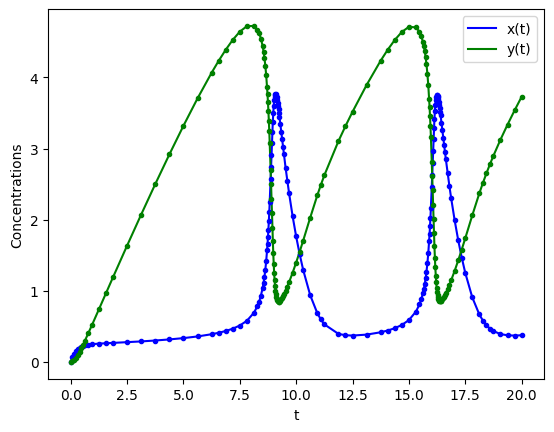

In [3]:
import numpy as np
import matplotlib.pyplot as plt

a = 1.0
b = 3.0
x_0 = 0.0
y_0 = 0.0
delta = 1e-10
t_0 = 0.0
t_f = 20.0
nmax = 8

def f_vec(r):
    x = float(r[0])
    y = float(r[1])
    dxdt = 1.0 - (b + 1.0) * x + a * (x * x) * y
    dydt = b * x - a * (x * x) * y
    return np.array([dxdt, dydt], dtype=float)

def solution(t_0, t_f):
    r0 = np.array([x_0, y_0], float)
    tpoints = [t_0]
    xpoints = [r0[0]]
    ypoints = [r0[1]]
    H0 = t_f - t_0

    def Bulirsch_Stoer_step(r_local, t_local, H_local):
        def modified_midpoint_step(r_mm, n):
            h = H_local / n
            r0 = r_mm.astype(float)
            k = r0 + 0.5 * h * f_vec(r0)
            rtemp = r0 + h * f_vec(k)
            for _ in range(n - 1):
                k = k + h * f_vec(rtemp)
                rtemp = rtemp + h * f_vec(k)
            return 0.5 * (rtemp + k + 0.5 * h * f_vec(rtemp))

        def compute_row_n(R1_row, n):
            if n > nmax:
                return None
            R2 = [modified_midpoint_step(r_local, n)]
            for m in range(2, n + 1):
                prev = R2[m - 2]
                prev_prev = R1_row[m - 2]
                denom = (n / (n - 1.0)) ** (2 * (m - 1)) - 1.0
                eps = (prev - prev_prev) / denom
                R2.append(prev + eps)
            eps_vec = (R2[n - 2] - R1_row[n - 2]) / (((n / (n - 1.0)) ** (2 * (n - 1))) - 1.0)
            error = np.linalg.norm(eps_vec)
            target_accuracy = H_local * delta
            if error < target_accuracy:
                return R2[n - 1]
            return compute_row_n(R2, n + 1)

        R1_initial = [modified_midpoint_step(r_local, 1)]
        return compute_row_n(R1_initial, 2)

    intervals = [(t_0, H0, r0.copy())]
    completed = []

    while intervals:
        t_start, H_interval, r_start = intervals.pop()
        r_end = Bulirsch_Stoer_step(r_start, t_start, H_interval)
        if r_end is None:
            H_half = 0.5 * H_interval
            intervals.append((t_start + H_half, H_half, None))
            intervals.append((t_start, H_half, r_start))
            continue
        completed.append((t_start + H_interval, r_end.copy()))
        if intervals:
            top = intervals[-1]
            if top[2] is None and abs(top[0] - (t_start + H_interval)) < 1e-12:
                intervals[-1] = (top[0], top[1], r_end.copy())
        continue

    completed_sorted = sorted(completed, key=lambda tr: tr[0])
    for (tt, rr) in completed_sorted:
        tpoints.append(tt)
        xpoints.append(rr[0])
        ypoints.append(rr[1])

    return np.array(tpoints), np.array(xpoints), np.array(ypoints)

t_vals, x_vals, y_vals = solution(t_0, t_f)

plt.plot(t_vals, x_vals, 'b-', label='x(t)')
plt.plot(t_vals, y_vals, 'g-', label='y(t)')
plt.plot(t_vals, x_vals, 'bo', markersize=3)
plt.plot(t_vals, y_vals, 'go', markersize=3)
plt.xlabel('t')
plt.ylabel('Concentrations')
plt.legend()
plt.show()
